# Week 1 — KRAS Mutation Subtypes and Tumor Immune Activity (TCGA LUAD)

**Goal:**  
Determine whether different KRAS mutation subtypes (e.g., G12C, G12D and others) are associated with differences in tumor immune activity in human lung adenocarcinoma.

**Background:**  
Experimental studies in mouse models have suggested that specific KRAS mutation subtypes can produce tumors with different oncogenic strength and immune phenotypes.  
However, it is unclear whether such subtype-driven immune differences are also detectable in human lung adenocarcinoma transcriptomic data.  
This analysis tests whether KRAS subtype alone is sufficient to explain variation in immune cytotoxic gene expression in TCGA tumors.

**Dataset:**  
TCGA LUAD RNA-seq TPM + somatic mutation data

**Author:** Siya Singh


In [ ]:
import pandas as pd 
import numpy as np 

In [31]:
maf = pd.read_csv("../data/mc3_LUAD.txt.gz", sep="\t", low_memory=False)

In [32]:
maf.head()

,sample,chr,start,end,reference,alt,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen
0,TCGA-05-4244-01,10,101814119,101814119,G,C,CPN1,Missense_Mutation,p.H366D,0.21,deleterious(0),probably_damaging(1)
1,TCGA-05-4244-01,10,129902901,129902901,G,A,MKI67,Silent,p.N2401N,0.04,NaN,NaN
2,TCGA-05-4244-01,10,21104601,21104606,TTACAC,-,NEBL,In_Frame_Del,p.S730_V731del,0.21,NaN,NaN
3,TCGA-05-4244-01,10,45652518,45652518,G,A,RP11-445N18.7,RNA,NaN,0.26,NaN,NaN
4,TCGA-05-4244-01,10,50667200,50667200,G,A,ERCC6,Silent,p.S1381S,0.26,NaN,NaN


In [33]:
kras = maf[maf["gene"] == "KRAS"]
kras.head()

,sample,chr,start,end,reference,alt,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen
33,TCGA-05-4244-01,12,25398285,25398285,C,A,KRAS,Missense_Mutation,p.G12C,0.35,deleterious(0.04),probably_damaging(0.993)
309,TCGA-05-4249-01,12,25398285,25398285,C,A,KRAS,Missense_Mutation,p.G12C,0.33,deleterious(0.04),probably_damaging(0.993)
707,TCGA-05-4250-01,12,25398285,25398285,C,A,KRAS,Missense_Mutation,p.G12C,0.54,deleterious(0.04),probably_damaging(0.993)
3833,TCGA-05-4390-01,12,25398284,25398284,C,A,KRAS,Missense_Mutation,p.G12V,0.44,deleterious(0),possibly_damaging(0.479)
4530,TCGA-05-4395-01,12,25398284,25398284,C,A,KRAS,Missense_Mutation,p.G12V,0.62,deleterious(0),possibly_damaging(0.479)


In [34]:
kras = kras[kras["Amino_Acid_Change"].notna()]

In [35]:
g12c = kras[kras["Amino_Acid_Change"].str.contains("G12C")]
g12d = kras[kras["Amino_Acid_Change"].str.contains("G12D")]

In [36]:
len(g12c), len(g12d)

(61, 19)

In [37]:
g12c_ids = set(g12c["sample"])
g12d_ids = set(g12d["sample"])

In [38]:
expr = pd.read_csv("../data/TCGA-LUAD.star_tpm.tsv.gz", sep="\t", index_col=0)

In [39]:
expr.shape

(60660, 589)

In [40]:
expr.columns = [c[:15] for c in expr.columns]

In [41]:
sum([c in expr.columns for c in g12c_ids]), sum([c in expr.columns for c in g12d_ids])

(59, 19)

In [42]:
expr.index[:10]

Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000457.14', 'ENSG00000000460.17', 'ENSG00000000938.13',
       'ENSG00000000971.16', 'ENSG00000001036.14', 'ENSG00000001084.13',
       'ENSG00000001167.14'],
      dtype='object', name='Ensembl_ID')

In [29]:
gtf = pd.read_csv(
    "../data/gencode.v44.annotation.gtf.gz",
    sep="\t",
    comment="#",
    header=None,
    low_memory=False
)


In [43]:
expr.index = expr.index.str.split(".").str[0]

In [44]:
gtf = gtf[gtf[2] == "gene"]

In [45]:
info = gtf[8]

gene_map = info.str.extract('gene_id "(.*?)";.*gene_name "(.*?)";')
gene_map.columns = ["Ensembl","Symbol"]
gene_map.head()

,Ensembl,Symbol
0,ENSG00000290825.1,DDX11L2
5,ENSG00000223972.6,DDX11L1
13,ENSG00000227232.5,WASH7P
26,ENSG00000278267.1,MIR6859-1
29,ENSG00000243485.5,MIR1302-2HG


In [46]:
gene_map["Ensembl"] = gene_map["Ensembl"].str.split(".").str[0]
expr.index = expr.index.str.split(".").str[0]

In [47]:
mapping = dict(zip(gene_map["Ensembl"], gene_map["Symbol"]))


In [48]:
expr["Symbol"] = expr.index.map(mapping)
expr = expr.dropna(subset=["Symbol"])
expr = expr.set_index("Symbol")

In [49]:
expr.index[:100]


Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA', 'STPG1', 'NIPAL3', 'LAS1L', 'ENPP4', 'SEMA3F', 'CFTR',
       'ANKIB1', 'CYP51A1', 'KRIT1', 'RAD52', 'MYH16', 'BAD', 'LAP3', 'CD99',
       'CD99', 'HS3ST1', 'AOC1', 'WNT16', 'HECW1', 'MAD1L1', 'LASP1', 'SNX11',
       'TMEM176A', 'M6PR', 'KLHL13', 'CYP26B1', 'ICA1', 'DBNDD1', 'ALS2',
       'CASP10', 'CFLAR', 'TFPI', 'NDUFAF7', 'RBM5', 'MTMR7', 'SLC7A2', 'ARF5',
       'SARM1', 'POLDIP2', 'PLXND1', 'AK2', 'CD38', 'FKBP4', 'KDM1A', 'RBM6',
       'CAMKK1', 'RECQL', 'VPS50', 'HSPB6', 'ARHGAP33', 'NDUFAB1', 'PDK4',
       'SLC22A16', 'ZMYND10', 'ABCB5', 'ARX', 'SLC25A13', 'ST7', 'CDC27',
       'SLC4A1', 'CALCR', 'HCCS', 'DVL2', 'PRSS22', 'UPF1', 'SKAP2', 'SLC25A5',
       'MCUB', 'HOXA11', 'POLR2J', 'DHX33', 'MEOX1', 'THSD7A', 'LIG3', 'RPAP3',
       'ACSM3', 'REXO5', 'CIAPIN1', 'SPPL2B', 'ATOSB', 'COPZ2', 'PRKAR2B',
       'MSL3', 'CREBBP', 'TSPOAP1', 'MPO', 'PON1', 'GCFC2', 'WDR54', 'CR

In [50]:
immune_genes = ["CD8A","CD8B","GZMB","PRF1","IFNG"]

[g for g in immune_genes if g in expr.index]


['CD8A', 'CD8B', 'GZMB', 'PRF1', 'IFNG']

In [51]:
immune_expr = expr.loc[immune_genes]
immune_score = immune_expr.mean()

In [52]:
g12c_scores = immune_score[immune_score.index.isin(g12c_ids)]
g12d_scores = immune_score[immune_score.index.isin(g12d_ids)]
len(g12c_scores), len(g12d_scores)

(59, 19)

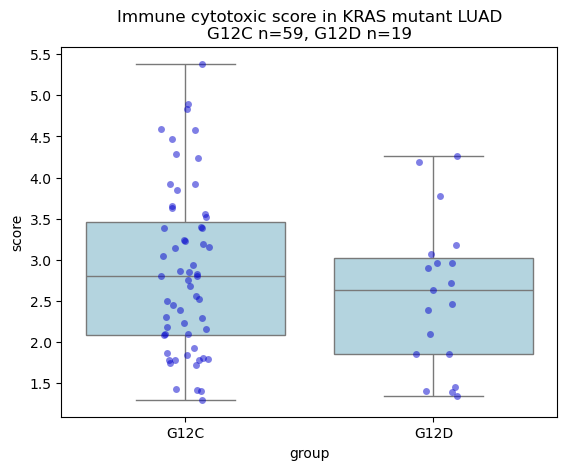

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame({
    "score": list(g12c_scores) + list(g12d_scores),
    "group": ["G12C"]*len(g12c_scores) + ["G12D"]*len(g12d_scores)
})

sns.boxplot(x="group", y="score", data=data, color="lightblue")
sns.stripplot(x="group", y="score", data=data, color="mediumblue", alpha=0.5)

plt.title(f"Immune cytotoxic score in KRAS mutant LUAD\nG12C n={len(g12c_scores)}, G12D n={len(g12d_scores)}")
plt.savefig("../figures/immune_score_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

In [54]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(g12c_scores, g12d_scores)

p


0.33105363543489874

In [55]:
data.to_csv("KRAS_week1_immune_scores.csv", index=False)

## Conclusion

In this analysis, human lung adenocarcinoma samples from TCGA were stratified by KRAS mutation subtype (G12C vs G12D). Gene expression TPM data were processed, Ensembl IDs were mapped to gene symbols, and a cytotoxic immune activity score was computed using canonical CD8 T-cell effector genes (CD8A, CD8B, GZMB, PRF1, IFNG).

Comparison of immune scores between KRAS G12C and G12D tumors showed largely overlapping distributions, with no strong visual separation between groups. Statistical testing using a Mann–Whitney U test did not indicate a substantial difference in cytotoxic immune activity between mutation subtypes in this human cohort.

These results suggest that, unlike controlled mouse models where KRAS subtype–specific immunogenic differences have been reported, immune activation differences between G12C and G12D tumors may be weaker in heterogeneous human lung cancers. This likely reflects additional biological variability in patients, including co-mutations, tumor evolution, and microenvironmental factors.

This Week-1 analysis establishes a reproducible workflow for mutation-specific tumor transcriptomics and motivates deeper investigation of genetic context (e.g., KRAS + TP53 or STK11 combinations) in subsequent analyses.
